In [110]:
#rm(list=ls())
suppressMessages(if(!require(tidyverse)) install.packages("tidyverse", repos = "http://cran.us.r-project.org"))                                 
suppressMessages(if(!require(stargazer)) install.packages("stargazer", repos = "http://cran.us.r-project.org"))                                 
suppressMessages(if(!require(car)) install.packages("car", repos = "http://cran.us.r-project.org"))
suppressMessages(if(!require(olsrr)) install.packages("olsrr", repos = "http://cran.us.r-project.org"))
suppressMessages(if(!require(lmtest)) install.packages("lmtest", repos = "http://cran.us.r-project.org"))
suppressMessages(if(!require(sandwich)) install.packages("sandwich", repos = "http://cran.us.r-project.org"))               
suppressMessages(if(!require(hcci)) install.packages("hcci", repos = "http://cran.us.r-project.org"))                                 

In [111]:
dados<-read_csv("/home/ffajardo/Dropbox/working_papers/Github/aulas/jupyter/datasets/food.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  food_exp = col_double(),
  income = col_double()
)




In [112]:
head(dados)

X1,food_exp,income
<dbl>,<dbl>,<dbl>
1,115.22,3.69
2,135.98,4.39
3,119.34,4.75
4,114.96,6.03
5,187.05,12.47
6,243.92,12.98



Call:
lm(formula = food_exp ~ income, data = dados)

Residuals:
     Min       1Q   Median       3Q      Max 
-223.025  -50.816   -6.324   67.879  212.044 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   83.416     43.410   1.922   0.0622 .  
income        10.210      2.093   4.877 1.95e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 89.52 on 38 degrees of freedom
Multiple R-squared:  0.385,	Adjusted R-squared:  0.3688 
F-statistic: 23.79 on 1 and 38 DF,  p-value: 1.946e-05


[1] 31 38

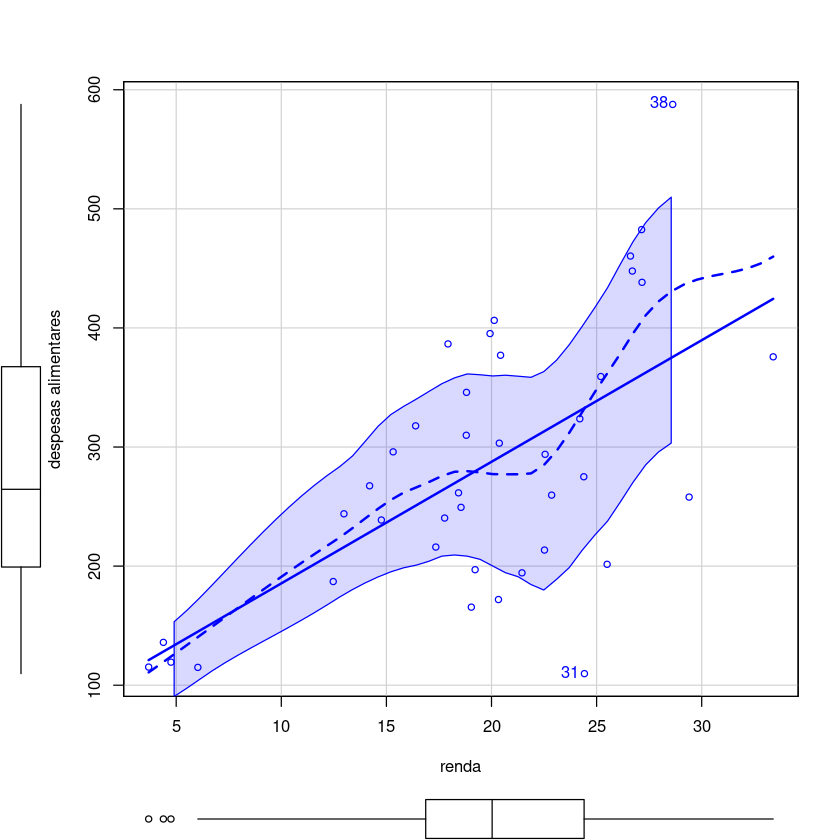

In [113]:
summary(fit <- lm(food_exp~income, data=dados))
scatterplot(food_exp ~ income, data=dados, id=list(n=2),xlab="renda", ylab="despesas alimentares")

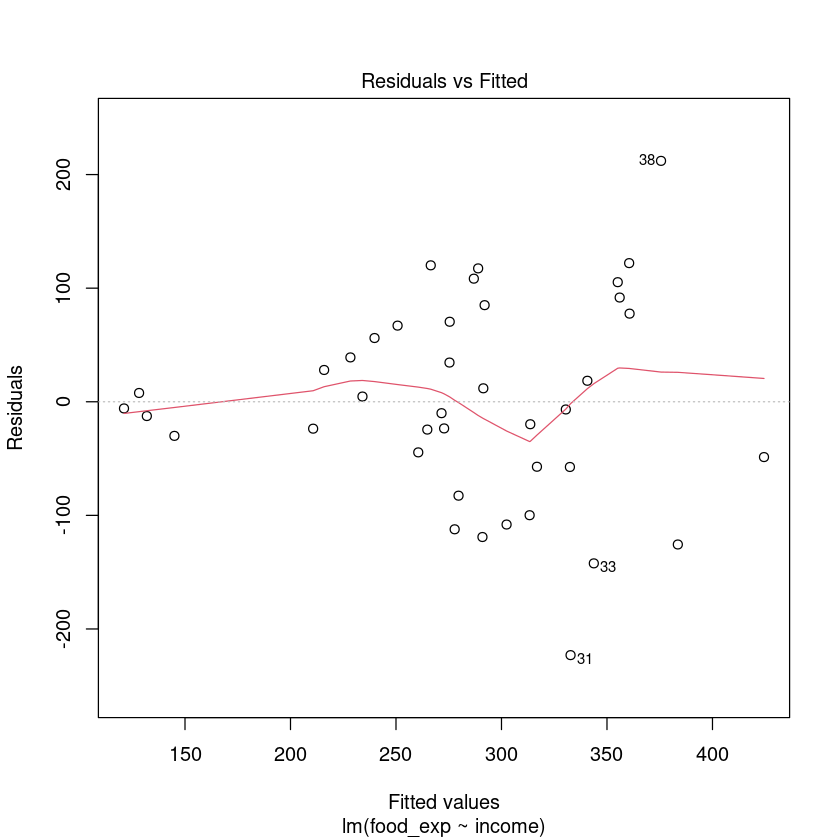

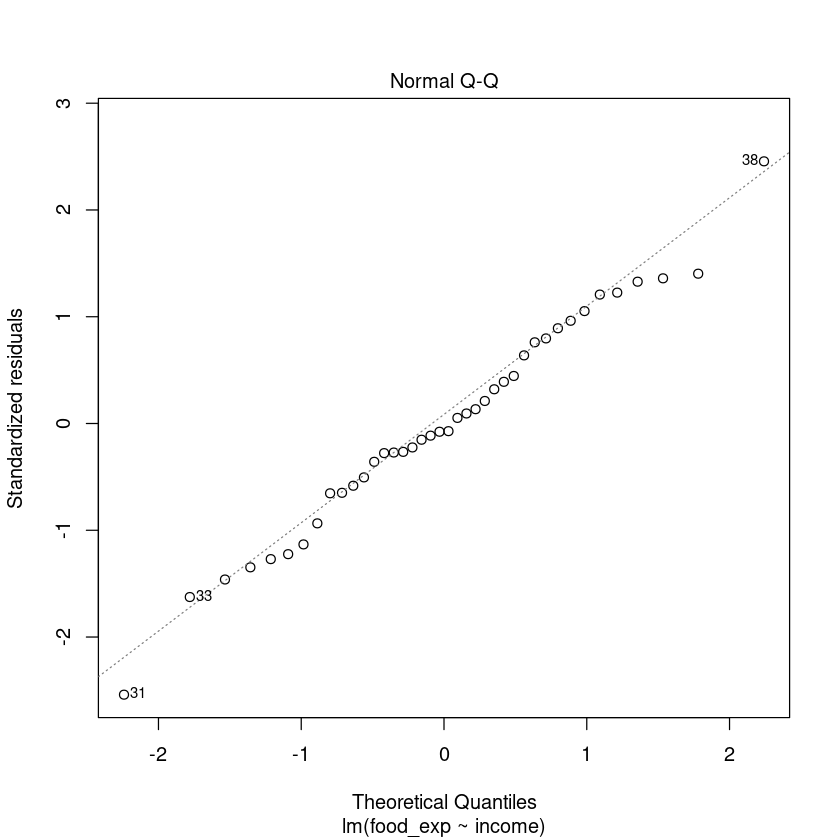

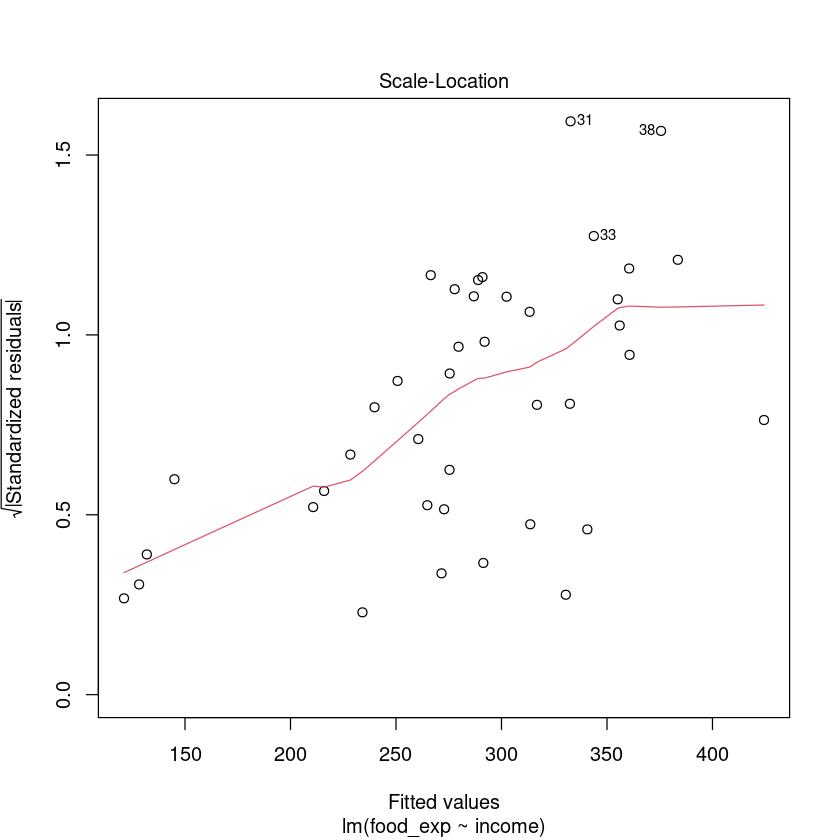

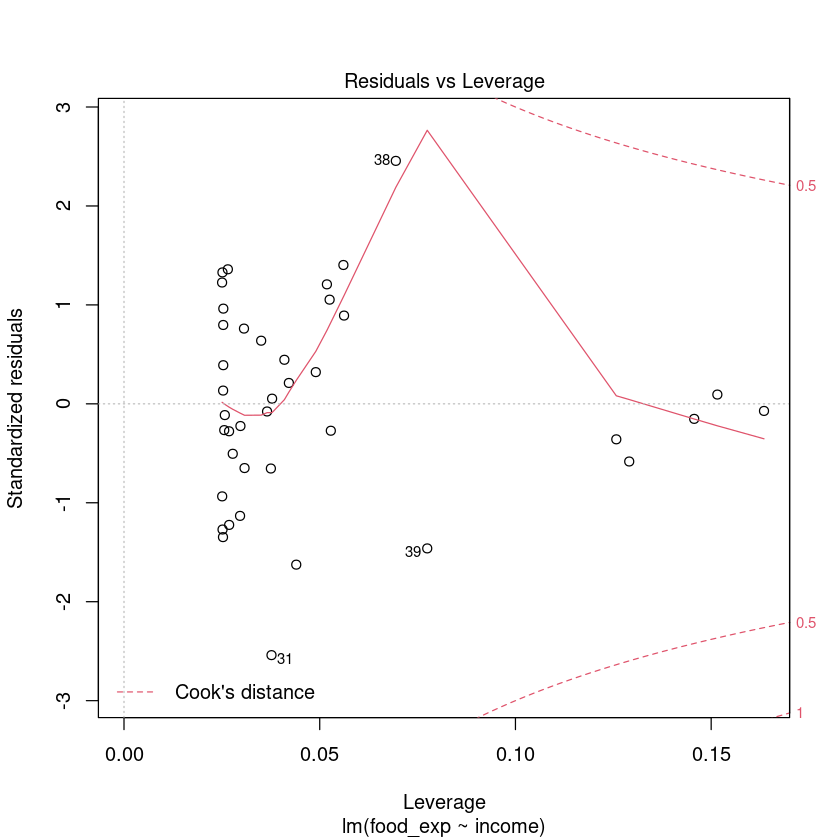

In [114]:
plot(fit)

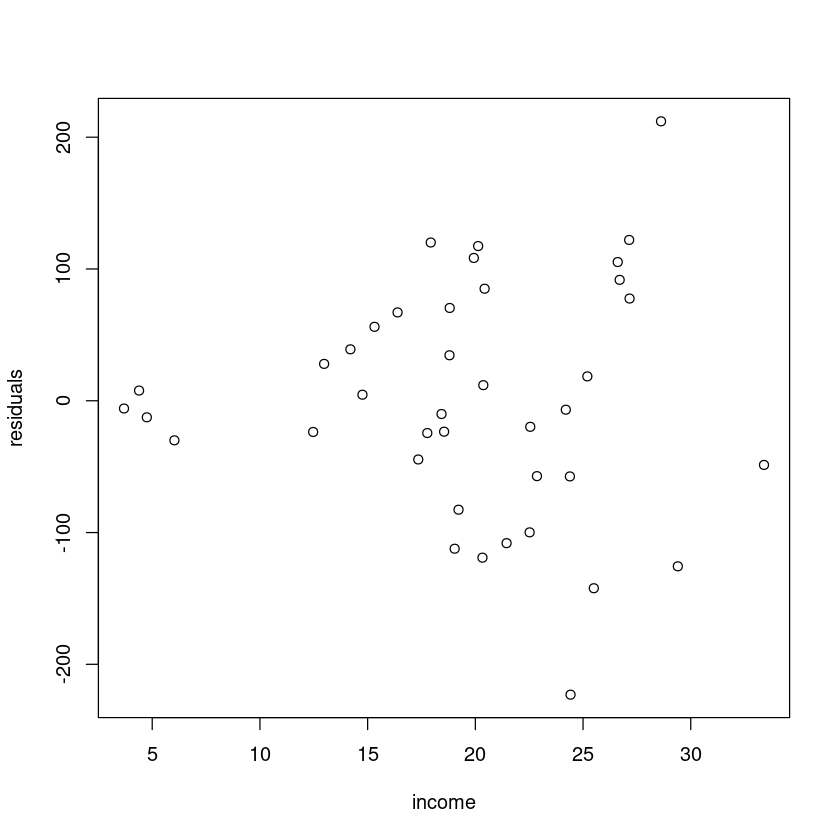

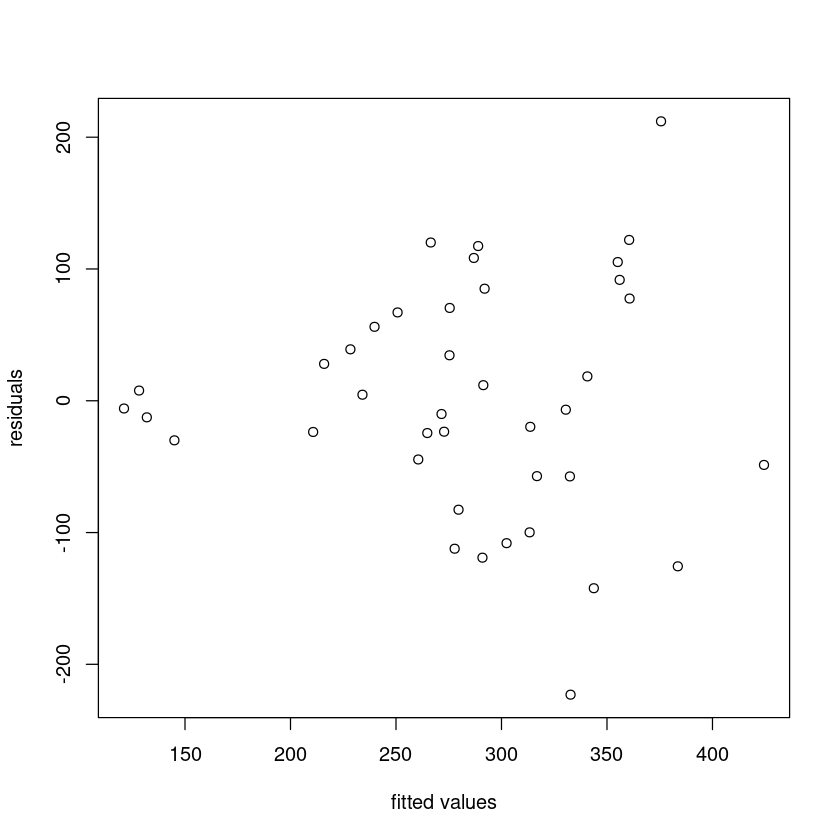

In [115]:
res <- residuals(fit)
yhat <- fitted(fit)
plot(dados$income,res, xlab="income", ylab="residuals")
plot(yhat,res, xlab="fitted values", ylab="residuals")

## Testes estatísticos para heteroscedasticidade

In [116]:
## White test
##
##  Testing constant variance  (http://en.wikipedia.org/wiki/White_test)
##
## To test for constant variance one undertakes an auxiliary
## regression analysis: this regresses the squared residuals from the
## original regression model onto a set of regressors that contain the
## original regressors, the cross-products of the regressors and the
## squared regressors. One then inspects the R2. The LM test statistic
## is the product of the R2 value and sample size:
##
##  LM = n*R^2
##
##  This follows a chi-square distribution, with degrees of freedom
##  equal to the number of estimated parameters (in the auxiliary
##  regression) minus one.
##
## 1. White, H. (1980). A Heteroskedasticity-Consistent Covariance
## Matrix Estimator and a Direct Test for
## Heteroskedasticity. Econometrica 48 (4): 817–838. JSTOR
## 1912934. MR575027.

## 2. Kim, E.H.; Morse, A.; Zingales, L. (2006). What Has Mattered to
## Economics since 1970. Journal of Economic Perspectives 20 (4):
## 189–202. doi:10.1257/jep.20.4.189.

white.test <- function(lmobj, squares.only=FALSE)
{
    stopifnot(class(lmobj)=='lm')
    mydata <- lmobj$model
    mydata[,1] <- lmobj$residual^2
    fml <- lmobj$call$formula
    formula1 <- paste(fml[2],fml[1],fml[3])
    pvs <- attr(lmobj$terms,"term.labels")
    k <- length(pvs);
    n <- length(lmobj$fit)
    
    for(i in 1:k){
        tmp <- NULL;
        if(substr(pvs[i],1,2)=="I("){
            tmp2 <- substr(pvs[i],3, nchar(pvs[i])-1);
        }else{
            tmp2 <- pvs[i];
        }
        for(j in 1:nchar(tmp2)){
            tmp1 <- substr(tmp2,j,j)
            if(tmp1 == ":")
                tmp <- paste(tmp, "*", sep='')
            else
                tmp <- paste(tmp, tmp1, sep='')
        }
        pvs[i] <- tmp
    }
    formula2 <- paste(fml[2],fml[1])
    for(i in 1:k){
        if(i>1)
            formula2 <- paste(formula2, "+", sep='')
        formula2 <- paste(formula2, "I(", pvs[i],")",sep='')
        if(squares.only){
            formula2 <- paste(formula2, "+I(", pvs[i], 
                              "*", pvs[i], ")", sep = "")
        }else{
            for(j in i:k)
                formula2 <- paste(formula2,"+I(",pvs[i],
                                  "*",pvs[j],")", sep='')
        }
    }

    method <- ifelse(squares.only,
                     "White test for constant variance, squares only",
                     "White test for constant variance")

    out <- lm(as.formula(formula2),data=mydata)
    if(summary(out)$r.squared == 1.0){
        RVAL <- NULL;
        warning("Test failed.  Possible reasons:\n\t (1) collinearity, or (2) sample size is not big enough for the White's test.");
    }else{
        LM = summary(out)$r.squared * n  
        names(LM) <- "White"
        df <- out$rank - 1
        names(df) <- "df";
        RVAL <- list(statistic = LM,
                     parameter = df,
                     method = method,
                     p.value= pchisq(LM,df,lower.tail=FALSE),
                     data.name=NULL)
        class(RVAL) <- "htest"
    }
    return(RVAL)
}


In [117]:
white.test(fit)


	White test for constant variance

data:  
White = 7.5551, df = 2, p-value = 0.02288


In [118]:
lmtest::bptest(fit)


	studentized Breusch-Pagan test

data:  fit
BP = 7.3844, df = 1, p-value = 0.006579


In [119]:
ols_test_breusch_pagan(fit)


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

                Data                 
 ------------------------------------
 Response : food_exp 
 Variables: fitted values of food_exp 

         Test Summary          
 ------------------------------
 DF            =    1 
 Chi2          =    7.343935 
 Prob > Chi2   =    0.006728939 

In [120]:
gqtest(fit)


	Goldfeld-Quandt test

data:  fit
GQ = 3.6148, df1 = 18, df2 = 18, p-value = 0.004596
alternative hypothesis: variance increases from segment 1 to 2


In [121]:
hmctest(fit)


	Harrison-McCabe test

data:  fit
HMC = 0.21896, p-value = 0.006


## Análise residual

[1] 31 38

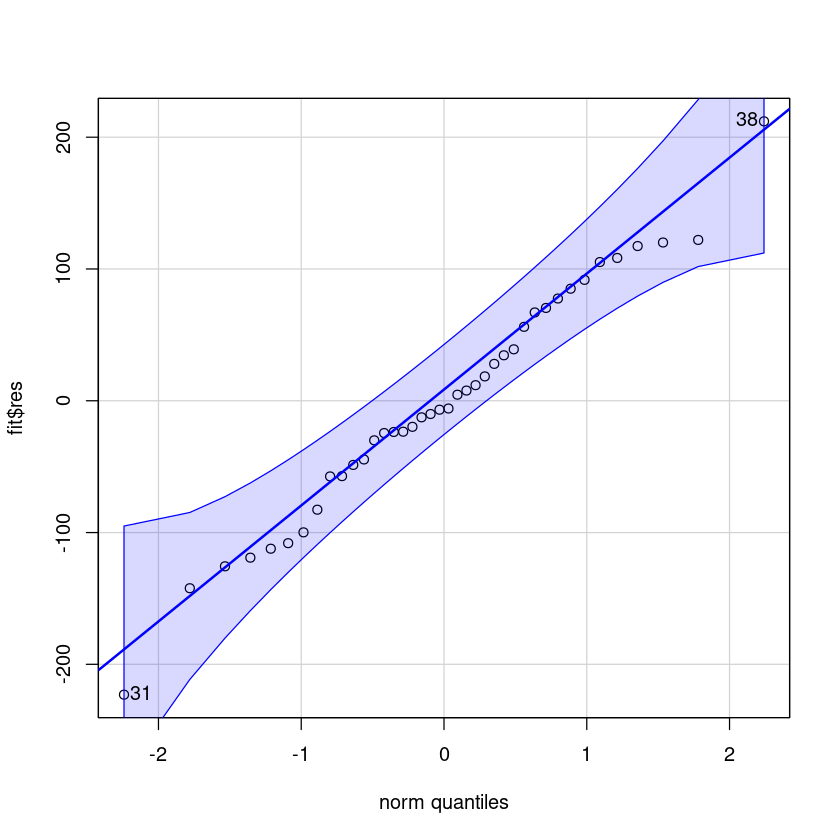

In [122]:
car::qqPlot(fit$res)

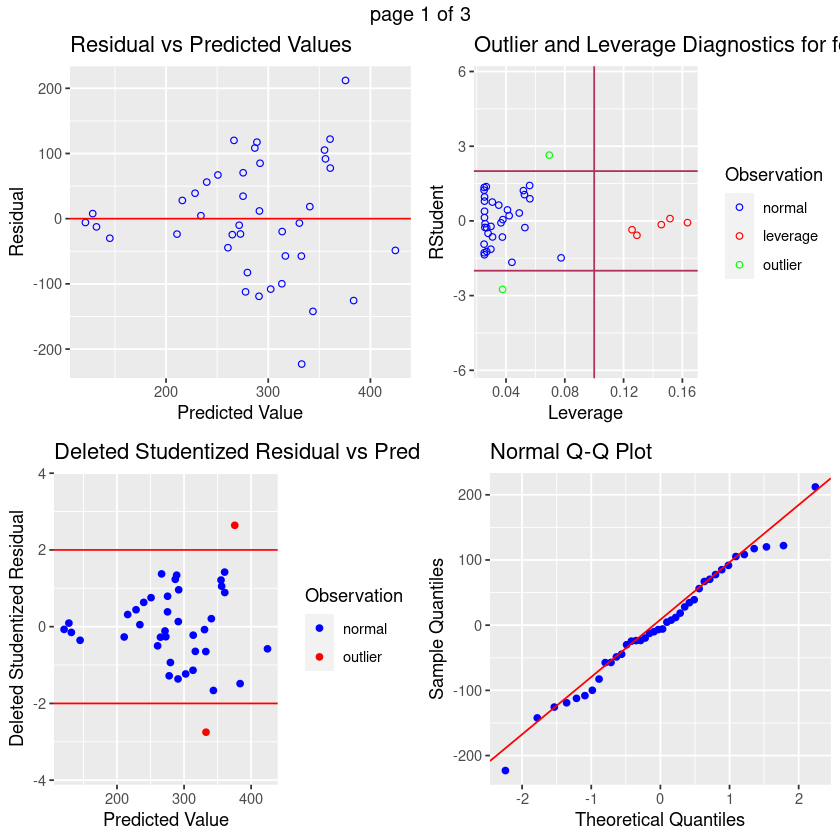

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL


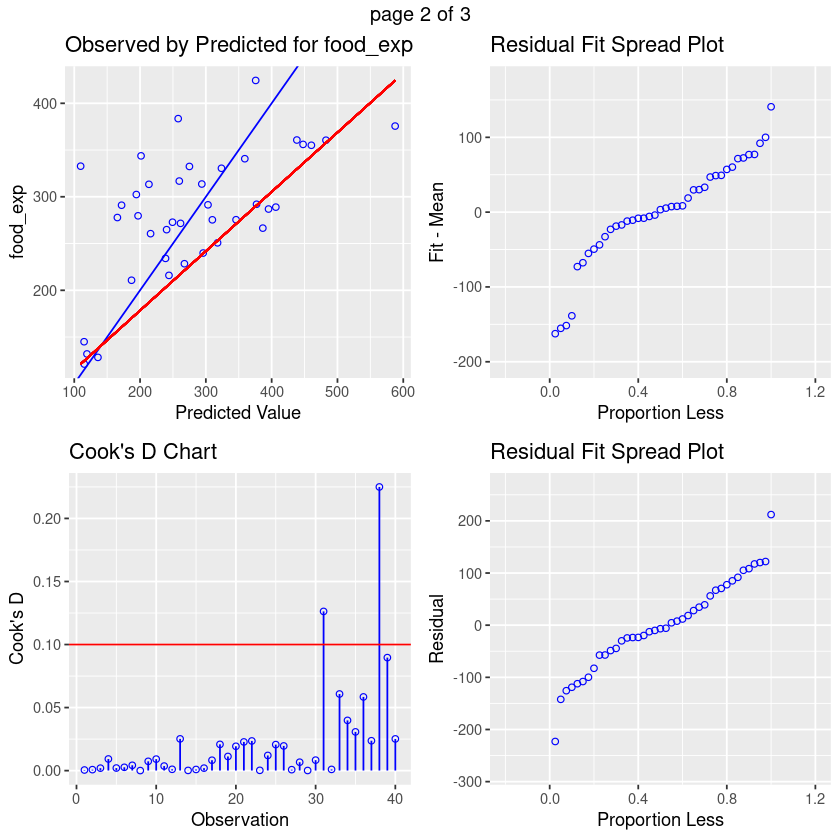

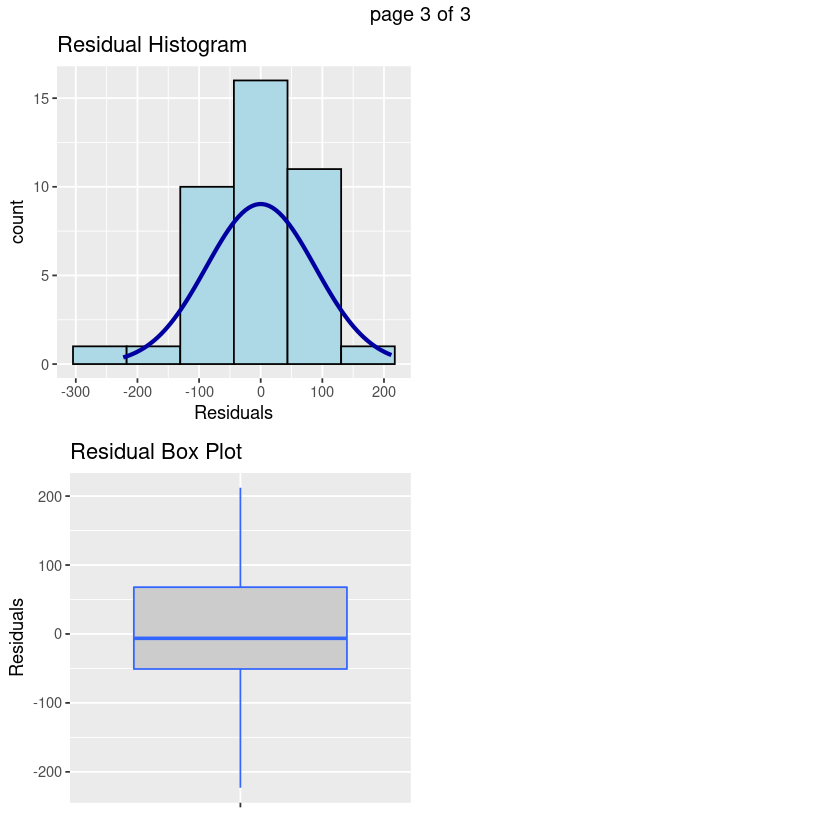

In [123]:
ols_plot_diagnostics(fit)

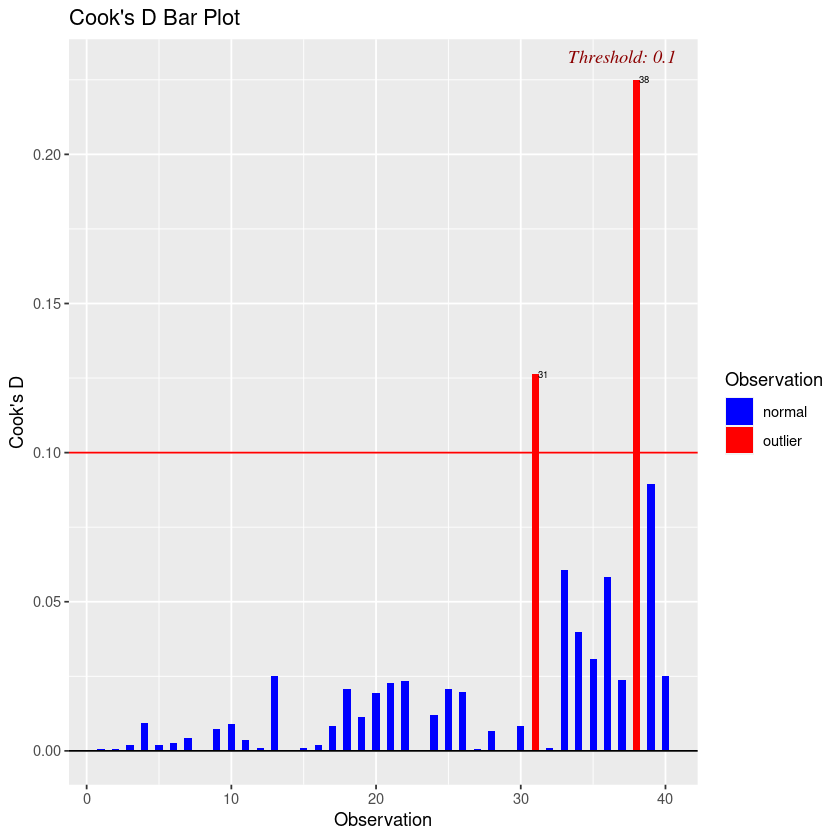

In [124]:
ols_plot_cooksd_bar(fit)

## Mínimos quadrados generalizados

In [125]:
summary(fit)


Call:
lm(formula = food_exp ~ income, data = dados)

Residuals:
     Min       1Q   Median       3Q      Max 
-223.025  -50.816   -6.324   67.879  212.044 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   83.416     43.410   1.922   0.0622 .  
income        10.210      2.093   4.877 1.95e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 89.52 on 38 degrees of freedom
Multiple R-squared:  0.385,	Adjusted R-squared:  0.3688 
F-statistic: 23.79 on 1 and 38 DF,  p-value: 1.946e-05


In [126]:
# Matrizes de covariância corrigidas por heterocedasticidade

cov1 <- car::hccm(fit, type="hc0"); cov1
food.HC1 <- coeftest(fit, vcov.=cov1); food.HC1

,(Intercept),income
(Intercept),716.54456,-43.897719
income,-43.89772,3.109121



t test of coefficients:

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  83.4160    26.7683  3.1162   0.00348 ** 
income       10.2096     1.7633  5.7902 1.105e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [127]:
hcci::HC(fit, method=0)

716.54456,-43.897719
-43.89772,3.109121


In [128]:
sandwich::vcovHC(fit,type="HC0")

,(Intercept),income
(Intercept),716.54456,-43.897719
income,-43.89772,3.109121


In [129]:
cov1 <- car::hccm(fit, type="hc1")
food.HC1 <- coeftest(fit, vcov.=cov1); food.HC1


t test of coefficients:

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  83.4160    27.4637  3.0373  0.004299 ** 
income       10.2096     1.8091  5.6436 1.755e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [130]:
w <- 1/dados$income
summary(food.gls <- lm(food_exp~income, weights=w, data=dados))
vcvfoodeq <- coeftest(fit, vcov.=cov1)


Call:
lm(formula = food_exp ~ income, data = dados, weights = w)

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-45.37 -11.13  -1.33  15.02  39.23 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   78.684     23.789   3.308  0.00206 ** 
income        10.451      1.386   7.541 4.61e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.75 on 38 degrees of freedom
Multiple R-squared:  0.5994,	Adjusted R-squared:  0.5889 
F-statistic: 56.87 on 1 and 38 DF,  p-value: 4.614e-09


In [131]:
food.ols <- lm(food_exp~income, data=dados)

ehatsq <- resid(food.ols)^2
sighatsq.ols  <- lm(log(ehatsq)~log(income), data=dados)
vari <- exp(fitted(sighatsq.ols))
food.fgls <- lm(food_exp~income, weights=1/sqrt(vari), data=dados)

# Biblioteca stargazer proporciona funções para deixar as tabelas em sintaxe html ou LaTeX

stargazer(food.ols, food.HC1, food.gls, food.fgls,
  header=FALSE, 
  title="Comparando diferentes modelos para os dados",
  type="html", # "html" or "latex" (in index.Rmd) 
  keep.stat="n",
  omit.table.layout="n",
  star.cutoffs=NA,
  digits=3, 
# single.row=TRUE,
  intercept.bottom=FALSE,
  column.labels=c("OLS","HC1","WLS","FGLS"),
  dep.var.labels.include = FALSE,
  model.numbers = FALSE,
  dep.var.caption="Covariável: 'food expenditure'",
  model.names=FALSE,
  star.char=NULL) # Oculta as estrelinhas


<table style="text-align:center"><caption><strong>Comparando diferentes modelos para os dados</strong></caption>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="4">Covariável: 'food expenditure'</td></tr>
<tr><td></td><td colspan="4" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td>OLS</td><td>HC1</td><td>WLS</td><td>FGLS</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Constant</td><td>83.416</td><td>83.416</td><td>78.684</td><td>78.070</td></tr>
<tr><td style="text-align:left"></td><td>(43.410)</td><td>(27.464)</td><td>(23.789)</td><td>(21.275)</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">income</td><td>10.210</td><td>10.210</td><td>10.451</td><td>10.487</td></tr>
<tr><td style="text-align:left"></td><td>(2.093)</td><td>(1.809)</td><td>

<table style="text-align:center"><caption><strong>Comparando diferentes modelos para os dados</strong></caption>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="4">Covariável: 'food expenditure'</td></tr>
<tr><td></td><td colspan="4" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td>OLS</td><td>HC1</td><td>WLS</td><td>FGLS</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Constant</td><td>83.416</td><td>83.416</td><td>78.684</td><td>78.070</td></tr>
<tr><td style="text-align:left"></td><td>(43.410)</td><td>(26.768)</td><td>(23.789)</td><td>(21.275)</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">income</td><td>10.210</td><td>10.210</td><td>10.451</td><td>10.487</td></tr>
<tr><td style="text-align:left"></td><td>(2.093)</td><td>(1.763)</td><td>(1.386)</td><td>(1.301)</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Observations</td><td>40</td><td></td><td>40</td><td>40</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr></table>

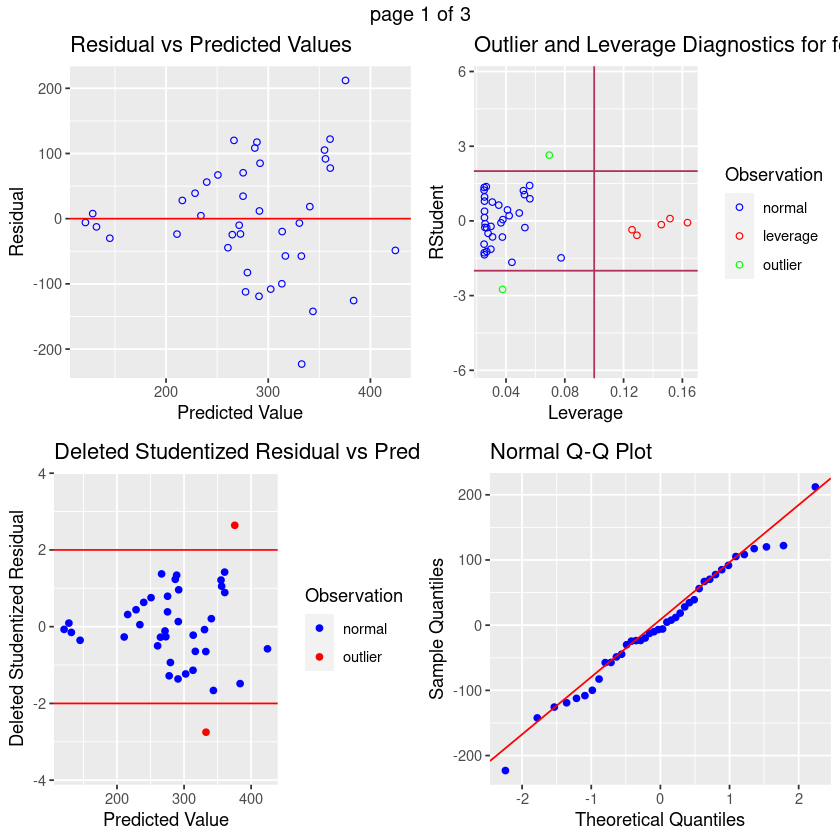

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL


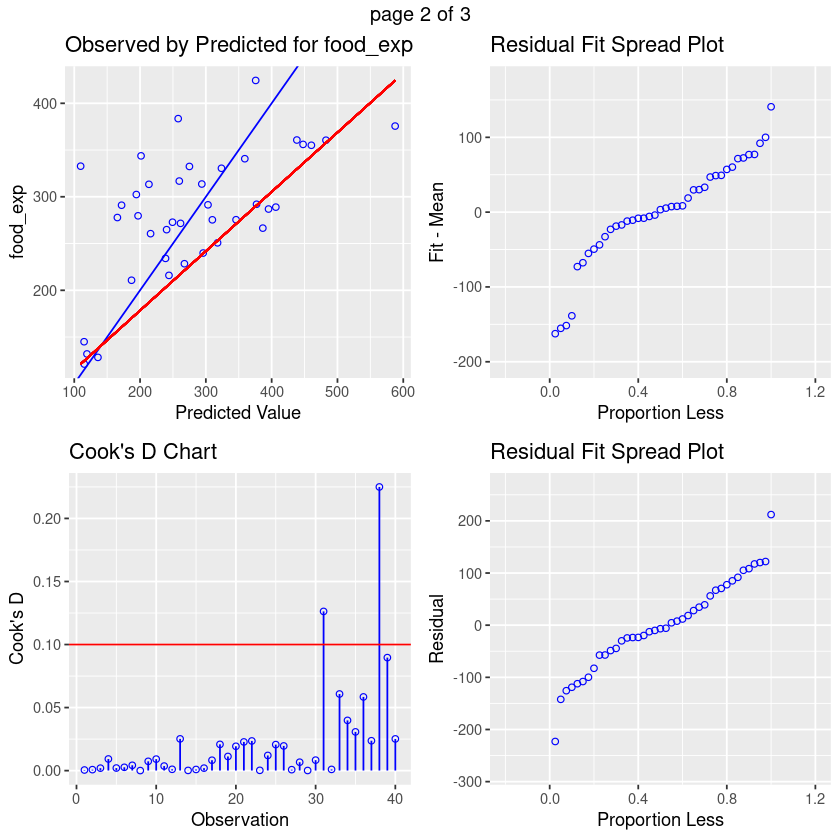

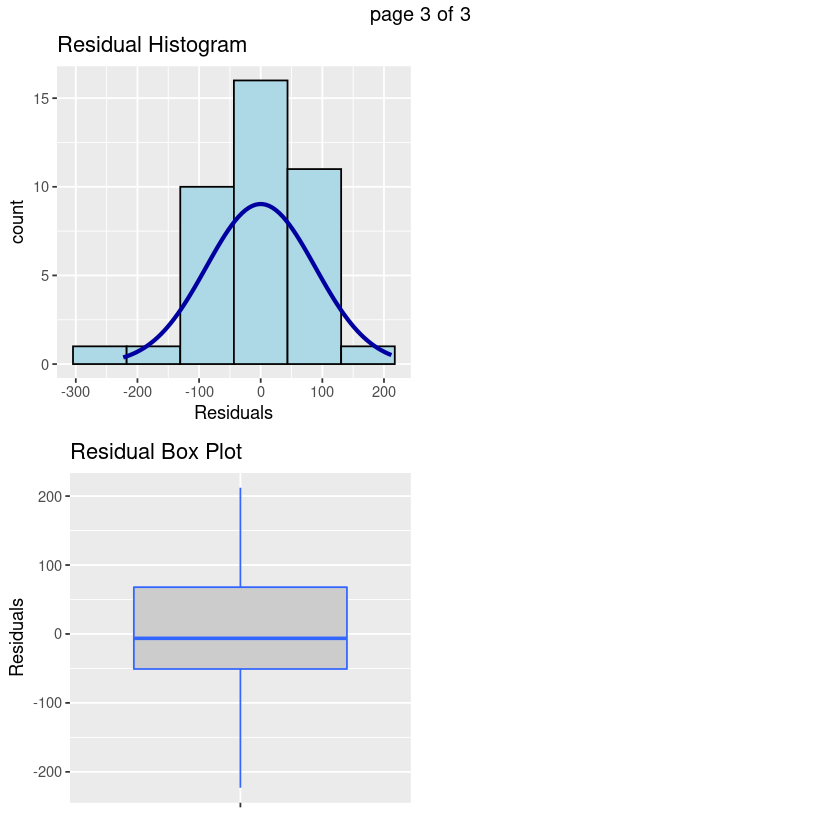

In [132]:
ols_plot_diagnostics(food.ols)

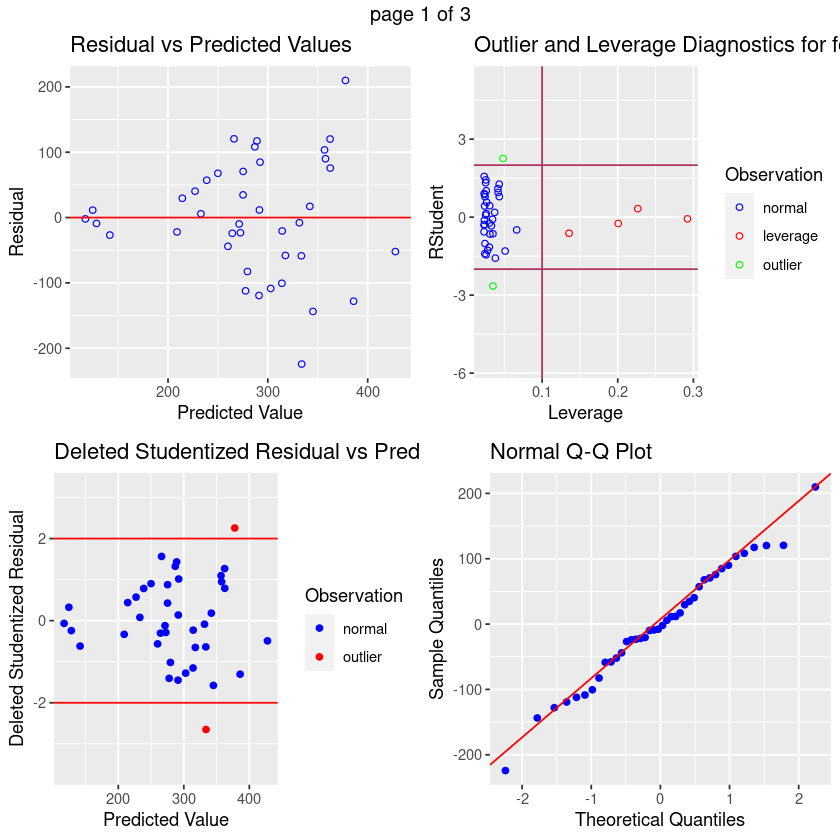

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL


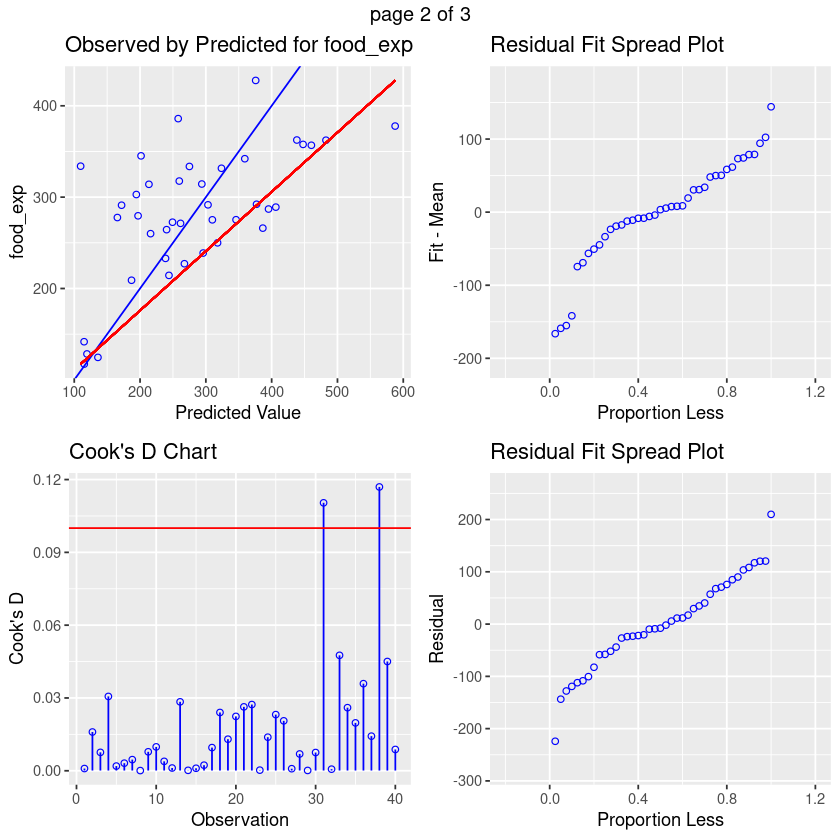

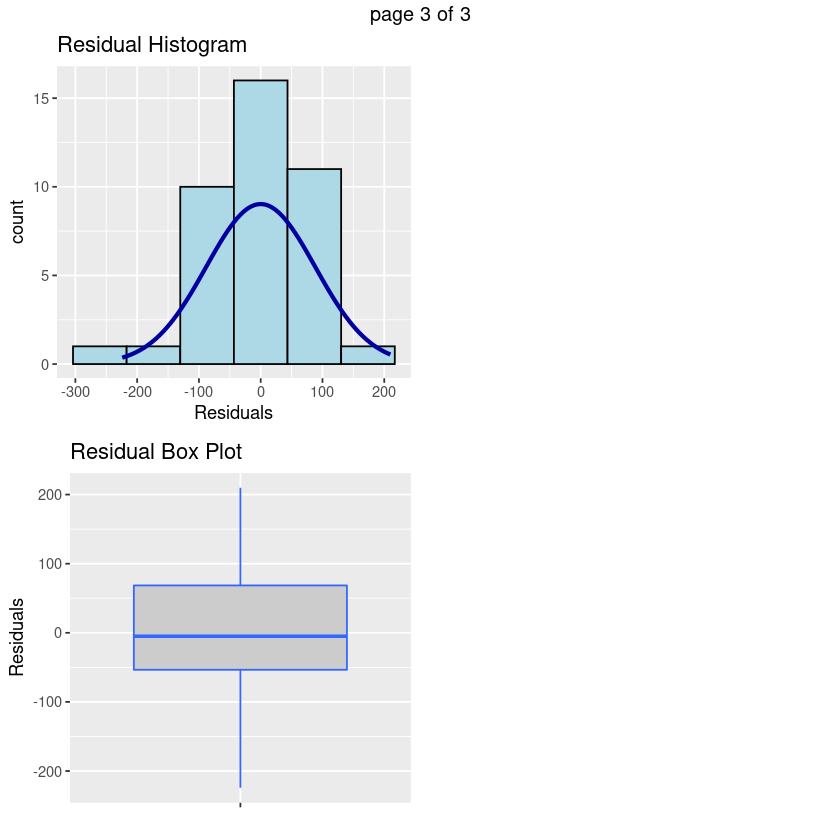

In [133]:
ols_plot_diagnostics(food.gls)

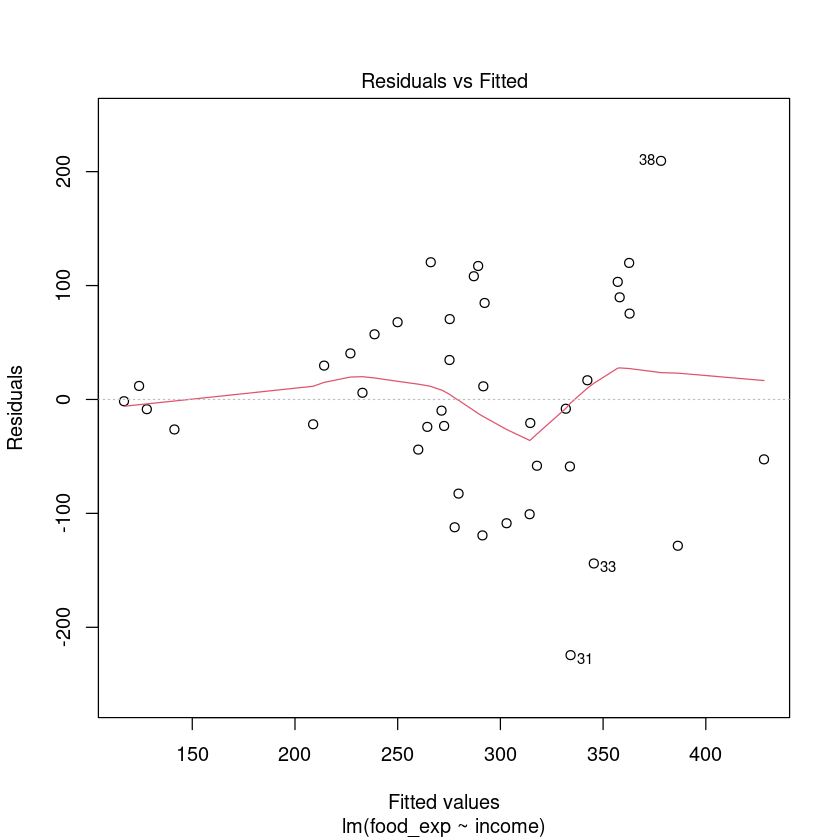

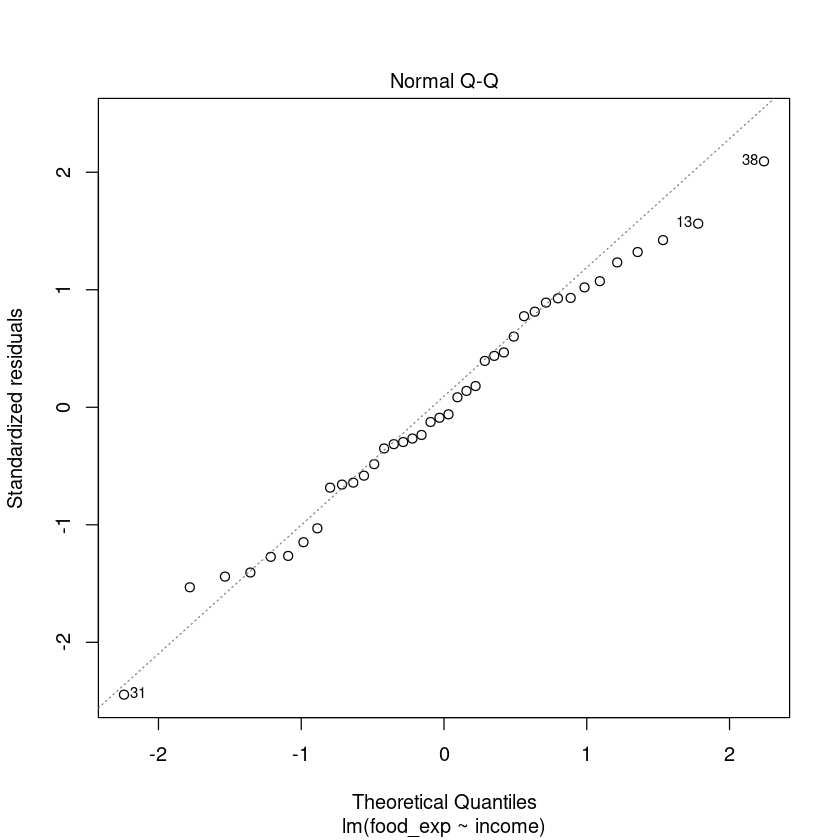

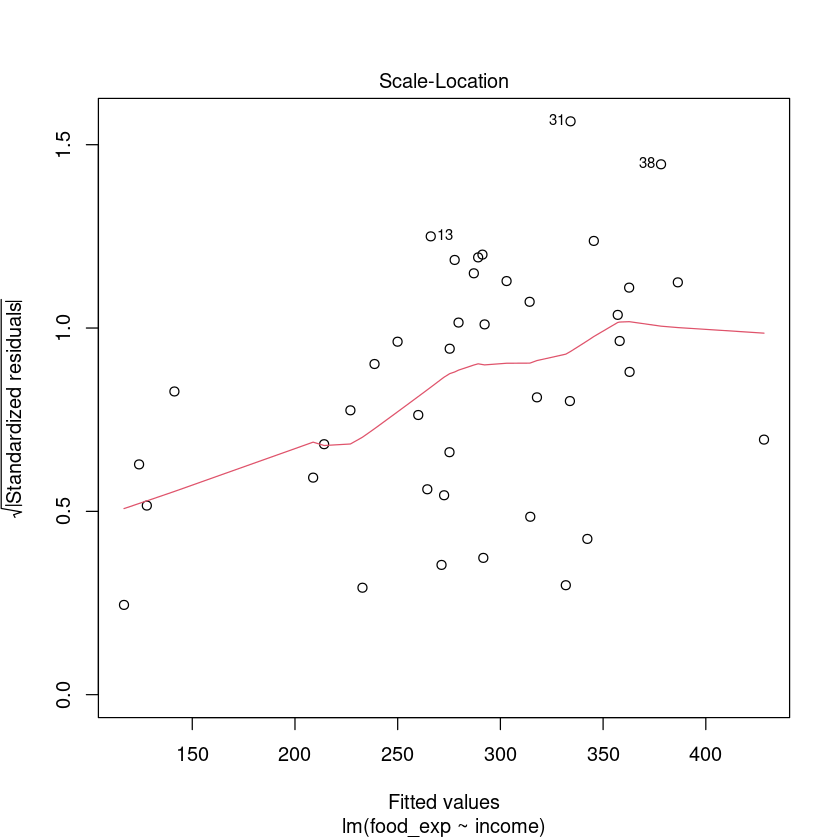

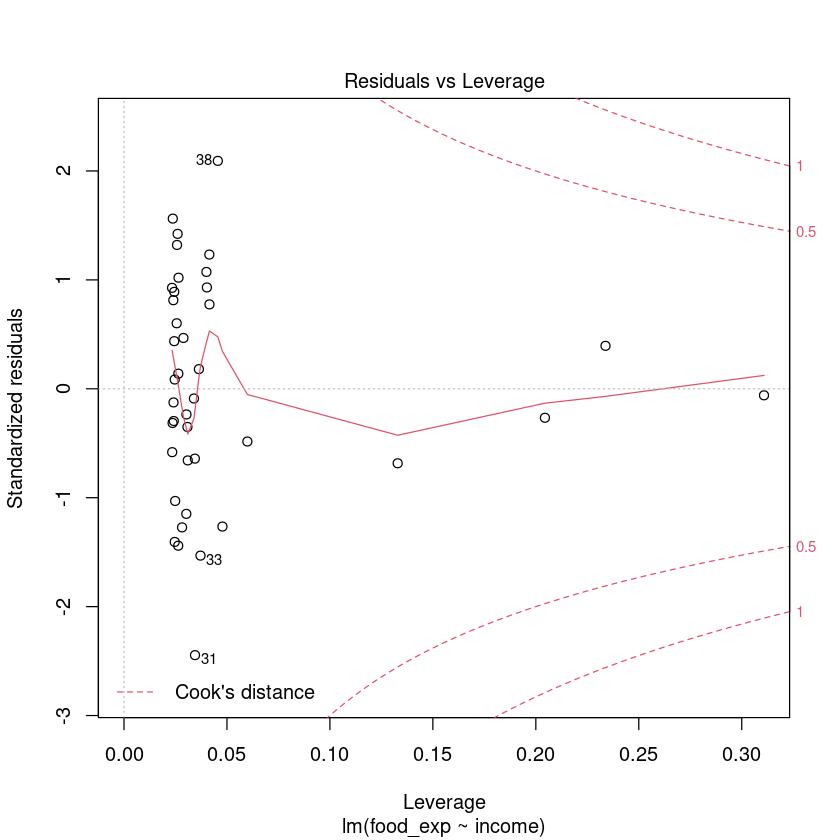

In [134]:
plot(food.fgls)

In [135]:
summary(food.fgls)


Call:
lm(formula = food_exp ~ income, data = dados, weights = 1/sqrt(vari))

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-27.6182  -7.2624  -0.7894   9.4541  23.4988 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   78.070     21.275    3.67 0.000743 ***
income        10.487      1.301    8.06  9.5e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.49 on 38 degrees of freedom
Multiple R-squared:  0.631,	Adjusted R-squared:  0.6212 
F-statistic: 64.97 on 1 and 38 DF,  p-value: 9.498e-10


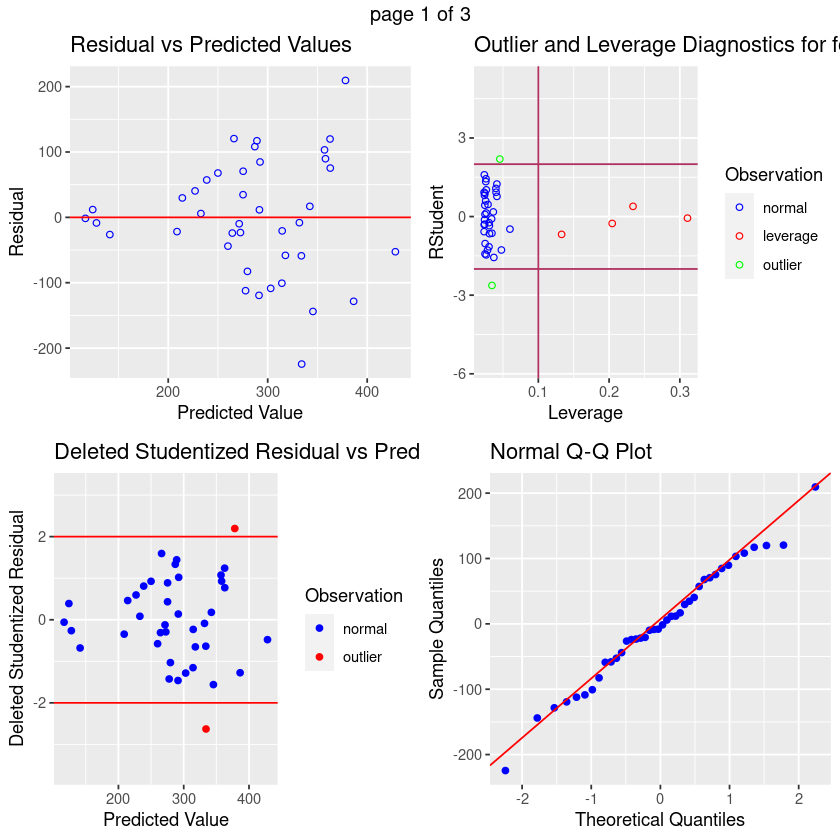

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL


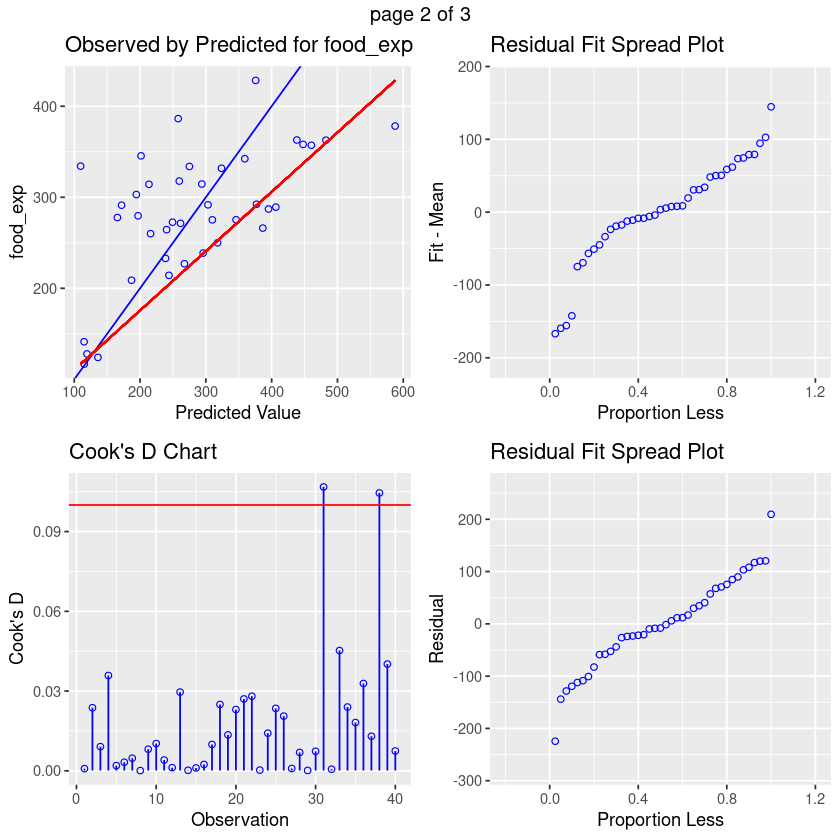

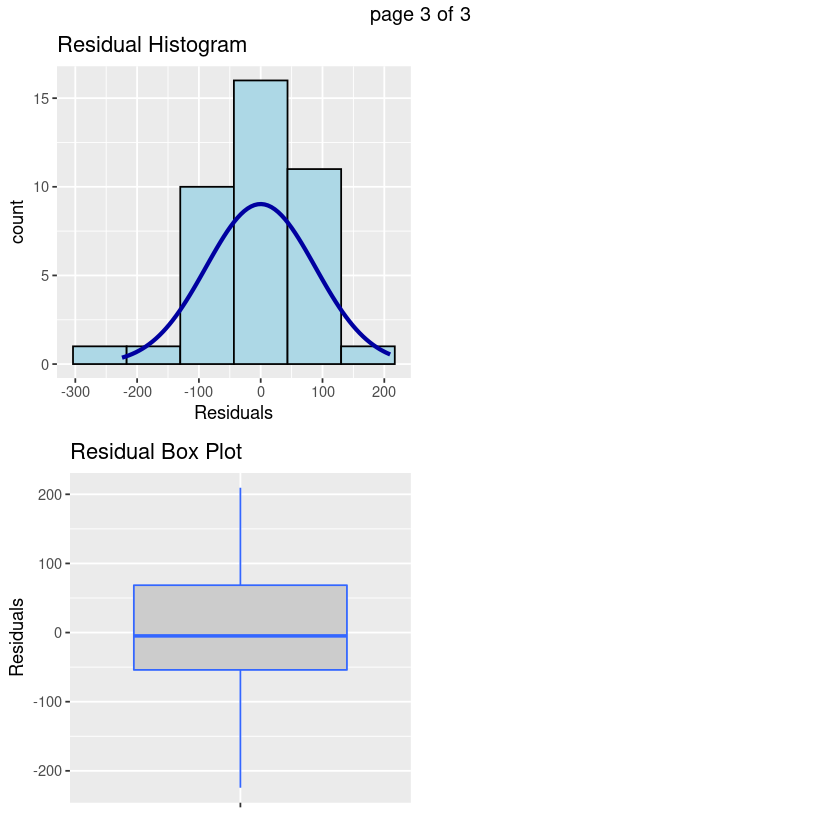

In [136]:
ols_plot_diagnostics(food.fgls)